In [1]:
# Imports
import numpy as np
import csv
import sklearn
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Ridge
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt

%matplotlib inline

# Predict via the user-specific median.
# If the user has no data, use the global median.

# Hard-code file names
train_file = 'data/LoanStats3e.csv' # 2016 Q1
train_file = 'data/LoanStats3a.csv' # 2007-2011
train_file = 'data/LoanStats3b.csv' # 2012-2013
train_file = 'data/LoanStats3c.csv' # 2014
# train_file = 'data/LoanStats3d.csv' # 2015

In [2]:
df = pd.read_csv(train_file, skiprows=1)
print df.shape

(235631, 115)


/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (0,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# FILTER OUT LOANS THAT ARE STILL CURRENT...
df = df[df['loan_status'] != 'Current']

feature_set = ['loan_amnt', 'installment', 'annual_inc', 'int_rate', 'dti', 'delinq_2yrs', 'revol_util']
features = df[feature_set]

def clean_percent(val):
    try:
        return float(val[:-1])
    except:
        return 0

def normalize_column(category, df, inplace=False):
    mean = np.nanmean(df[category])
    col_std = np.std(df[category])
    normed = df[category].apply(lambda x: x if pd.isnull(x) else (x - mean)/col_std)

    if inplace:
        df[category] = normed
    else:
        return normed

    
features['int_rate'] = pd.Series(features['int_rate']).str.replace('%', '').astype(float)
features['int_rate'] = np.log(features['int_rate'])
features['revol_util'] = features['revol_util'].apply(clean_percent)

for feature in feature_set:
    normalize_column(feature, features, True)


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

In [4]:
total_return = (df['total_pymnt'] + df['recoveries'] - df['collection_recovery_fee'])/df['loan_amnt']

# Add cleaned_results back to features data frame
features['total_return'] = total_return

def binary_loan_status(status):
    try:
        if status.find('Fully Paid'):
            return 1
        else:
            return 0
    except:
        return 0

features['binary_loan_status'] = map(lambda result: binary_loan_status(result), df['loan_status'])

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [5]:
df['loan_status'].value_counts()

Fully Paid            73905
Charged Off           21266
Late (31-120 days)     3940
In Grace Period        2522
Late (16-30 days)       817
Default                  66
Name: loan_status, dtype: int64

In [6]:
# count number of null rows
print np.sum(pd.isnull(features))
features = features.dropna(axis=0)

loan_amnt             2
installment           2
annual_inc            2
int_rate              2
dti                   2
delinq_2yrs           2
revol_util            0
total_return          2
binary_loan_status    0
dtype: int64


In [7]:
X = features.drop(['total_return', 'binary_loan_status'], axis=1)
y = features[['total_return']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=37)

In [8]:
X_classifier = features.drop(['total_return', 'binary_loan_status'], axis=1)
y_classifier = features[['binary_loan_status']]

X_classifier_train, X_classifier_test, y_classifier_train, y_classifier_test = train_test_split(X_classifier, y_classifier, test_size=0.20, random_state=37)

In [9]:
# Compare Ridge Regressor output with actual values... It's so far off.

ridge_regressor = Ridge(alpha=0.5)
ridge_regressor.fit(X_train, y_train)

y_predict = ridge_regressor.predict(X_train)

# for idx in xrange(100):
#     print "%.2f, %.2f" % (y_train.iloc[idx], y_predict[idx])

In [23]:
rf_regressor = RandomForestRegressor(n_estimators=150, min_samples_split=10, max_depth=10)
rf_regressor.fit(X_train, y_train)

rf_classifier = RandomForestClassifier(n_estimators=150, min_samples_split=10)
rf_classifier.fit(X_classifier_train, y_classifier_train)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [24]:
predicted_y = rf_regressor.predict(X_test)
class_col = (predicted_y > 1.0)
faux_binary_loan_status = (y_test['total_return'] > 1.0)
accuracy = np.sum(class_col == faux_binary_loan_status) / float(len(y_test))
print accuracy

predicted_y = rf_classifier.predict(X_classifier_train)
print rf_classifier.score(X_classifier_train, y_classifier_train)

0.532091299259
0.930961322733


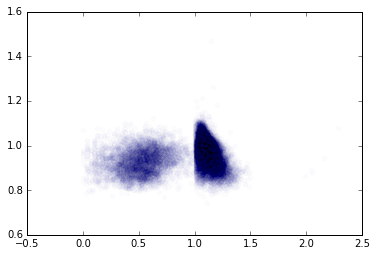

Testing error - Ridge Score was: 1714.369346


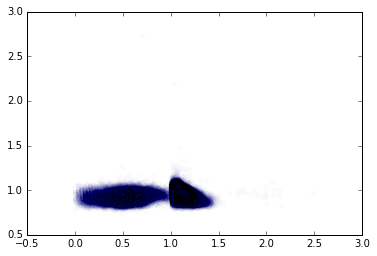

Training error - Ridge Score was: 6811.981708


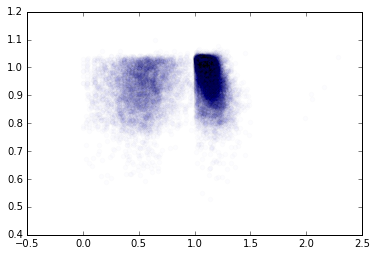

Testing error - RandomForest Score was: 1694.518107


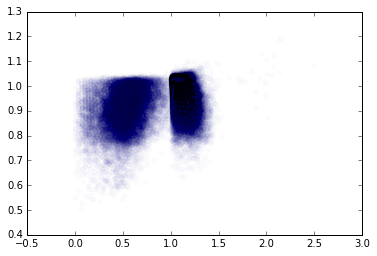

Training error - RandomForest Score was: 6134.351527


In [12]:
def score(regressor, X, y):
    predicted_y = regressor.predict(X)
    plt.scatter(y, predicted_y, alpha=0.01)
    plt.show()
    return np.sum(np.square(y - np.reshape(predicted_y, (len(predicted_y),1))))

# print regressor.predict(X_test)

print "Testing error - Ridge Score was: %f" % (score(ridge_regressor, X_test, y_test))
print "Training error - Ridge Score was: %f" % (score(ridge_regressor, X_train, y_train))

print "Testing error - RandomForest Score was: %f" % (score(rf_regressor, X_test, y_test))
print "Training error - RandomForest Score was: %f" % (score(rf_regressor, X_train, y_train))

In [13]:
# SNIPPET TO BROWSE LOANS VIA LENDING CLUB API
# NB: JSON KEYS DO NOT MATCH WITH CSV DATA...

import json
import pprint
import requests

pp = pprint.PrettyPrinter(indent=4)
s = requests.Session()
s.headers.update({'Authorization':'ZRYl2TYNY6v0yL/Cozf7B9US+uc='})
r = s.get('https://api.lendingclub.com/api/investor/v1/loans/listing')
# pp.pprint(json.loads(r.text))

Some thoughts...
- We should be able to take in the entire feed of loans and rank loans by a "quality metric"
- What is quality? Perhaps it should be a mismatch on the interest rate? The problem with this is that the IR is assigned by LendingClub
- Perhaps, it should be the overall return for a given loan (e.g. Interest Pymnts + Principal Pymnts + Late Fees + Recoveries - Recovery Collection Fee)

Feature Engineering...
- Installment / Income
- DTI

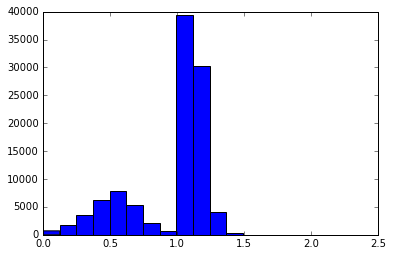

In [14]:
# Distribution of loan payoff behavior... When you get close to paying a loan off, you just pay it off.
p = plt.hist(features['total_return'], bins=20)